# Ezequiel Garcia - Tobias Giacri

## Inicializacion / Set-up de environment

In [23]:
# pip install scikit-learn
# pip install numpy
# pip install matplotlib

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time

## Carga de datos

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda   = np.loadtxt("samplesVDA1.txt")

cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000

data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)

# Divide los datos en conjuntos de entrenamiento y prueba de manera aleatoria
vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2, random_state=42)

data = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
dataTest = np.hstack((tiempo_prueba,vda_prueba)) # datos testing

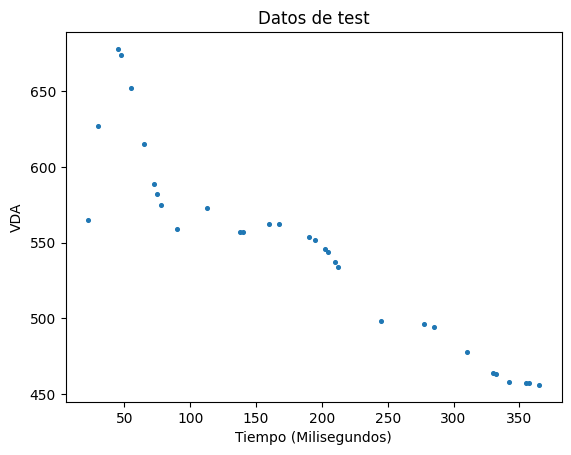

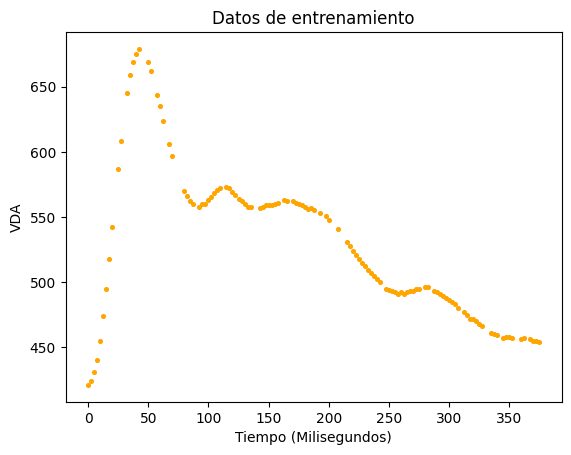

In [26]:
plt.figure()
plt.scatter(tiempo_prueba, vda_prueba, s = 7)
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')
plt.title('Datos de test')
plt.legend
plt.show()

plt.scatter(tiempo_entrenamiento, vda_entrenamiento, s=7, c='orange')
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')
plt.title('Datos de entrenamiento')
plt.show()


## CLUSTERING K-MEANS
Definicion de funcion

In [27]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def clusteringk(data,nclusters,mostrar=True):

    # Crear un objeto KMeans
    kmeans = KMeans(n_clusters=nclusters, n_init=19)

    # Ajustar el modelo a tus datos
    kmeans.fit(data)

    # Obtener los centroides de los clusters
    centroides = kmeans.cluster_centers_

    # Obtener las etiquetas de cluster para cada punto de datos
    etiquetas = kmeans.labels_

    if mostrar:

        # Visualizar los resultados
        plt.scatter(data[:, 0], data[:, 1], c=etiquetas)
        plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=200, linewidths=3, color='r')
        plt.title(f'Clustering con K-Means (k={nclusters})')
        plt.show()
        
    return etiquetas,centroides


## Algoritmo de Sugeno
Modificado para funcionar con K-means

In [28]:
"""
Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.
"""


def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

######################################################################

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

#################################################################################################################

# ESTA EDITADO EL DEF VIEW PARA AGRANDAR EL ESPACIO EN X EN EL GRAFICO

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        #x = np.linspace(self.minValue -400,self.maxValue + 400,30)

        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

##################################################################################################################

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []


###################################################################################################################
    def genfis(self, data, clusters, mostrar = True):

        start_time = time.time()
        #El método comienza midiendo el tiempo de ejecución.

        labels, cluster_center = clusteringk(data,clusters,mostrar) # Se cambio el clustering substractivo a kmeans (numero de clusters como entrada)

        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]
         #  Se calcula el número de clusters obtenidos (n_clusters) a partir de los centroides y se recorta la última columna de cluster_center,
         #  que generalmente contiene información adicional que no se utiliza en el modelo Sugeno.


        P = data[:,:-1]
        # Se obtienen las variables de entrada P a partir de los datos de entrada data. Luego,
        #  se calculan los valores máximos (maxValue) y mínimos (minValue) de cada variable de entrada.

        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        #  Se crea una lista de objetos fisInput para cada variable de entrada. Cada objeto fisInput se inicializa con su valor máximo, mínimo y
        #  los centroides de los clusters correspondientes a esa variable.
        self.rules = cluster_center
        self.entrenar(data)
        print("--- Tiempo de ejecucion %s seconds ---" % (time.time() - start_time))

######################################################################################################################
    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
# P contiene las variables de entrada del conjunto de datos data.
# T contiene las salidas deseadas (target) del conjunto de datos data.
        
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        #Aquí se calcula la desviación estándar sigma para las funciones de membresía gaussianas utilizadas en el sistema Sugeno.
        #  self.inputs contiene información sobre las variables de entrada.
        
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        #  Se calcula la activación de cada regla para cada instancia del conjunto de datos P.
        #  Esto se hace multiplicando las funciones de membresía gaussianas por cada regla y luego tomando el producto.
        #  El resultado es una lista de valores de activación para cada regla y cada instancia de entrada.

        nivel_acti = np.array(f).T
        #  nivel_acti es una matriz donde cada fila corresponde a una instancia del conjunto de datos y cada columna corresponde a una regla.
        #  Contiene los valores de activación de cada regla para cada instancia.


        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        # sumMu es un vector que contiene la suma de los valores de activación para cada instancia. 
        # Esto se usa en el cálculo de los coeficientes del sistema Sugeno.
        #print("sumMu")
        #print(sumMu)

        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        # Aquí se preparan los datos para el cálculo de los coeficientes. Se añade una columna de unos a la matriz P, 
        # luego se calculan las matrices acti e inp que se utilizan para construir la matriz de coeficientes A.
        


        A = acti*inp/sumMu
        #A es la matriz de coeficientes que se utiliza en el sistema de ecuaciones lineales.

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #Se resuelve el sistema de ecuaciones lineales utilizando mínimos cuadrados y se almacenan las soluciones en self.solutions.
        #print(solutions)
        return 0


###############################################################################################################
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

#  En resumen, este tramo toma un conjunto de datos de entrada y utiliza el sistema Sugeno previamente entrenado para calcular las salidas correspondientes.
#  este método asume que las variables de entrada y las reglas ya están configuradas en la instancia de la clase fis y
#  que los coeficientes del sistema Sugeno se han calculado previamente durante el entrenamiento


#################################################################################################################

    def viewInputs(self):
        for input in self.inputs:
            input.view()






## Entrenamiento


--- Tiempo de ejecucion 0.030043363571166992 seconds ---
141.484859925273


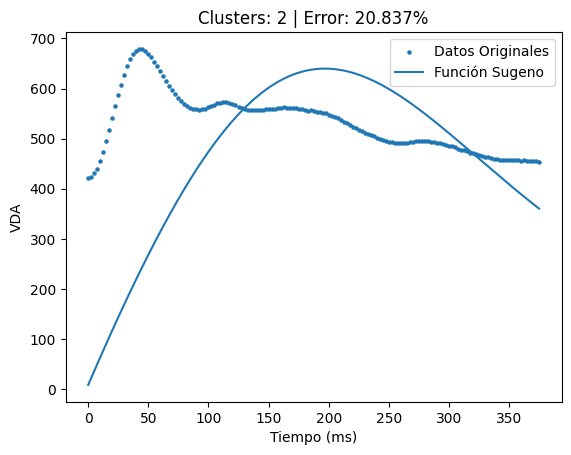

--- Tiempo de ejecucion 0.03530073165893555 seconds ---
20.404281144201846


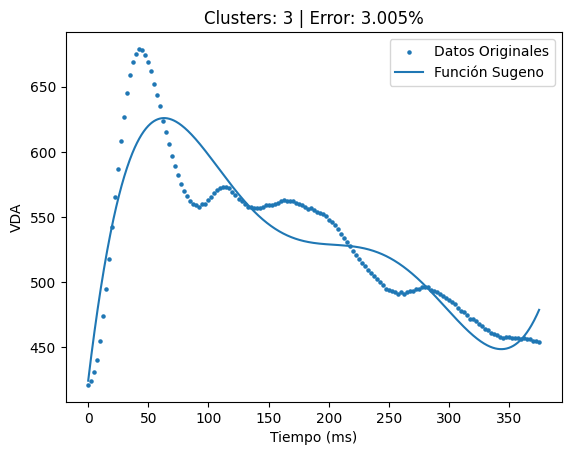

--- Tiempo de ejecucion 0.032859086990356445 seconds ---
21.907996572506406


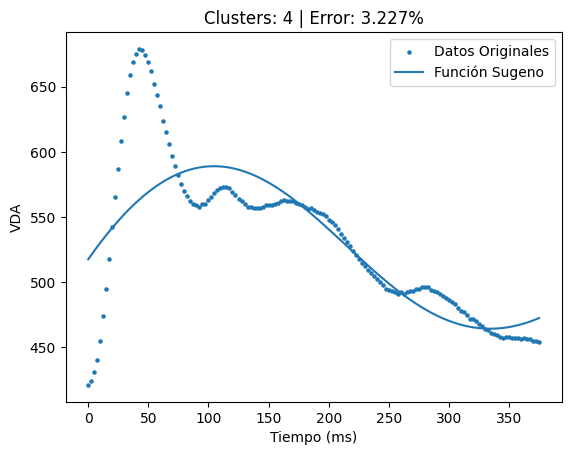

--- Tiempo de ejecucion 0.04053831100463867 seconds ---
9.221747442599266


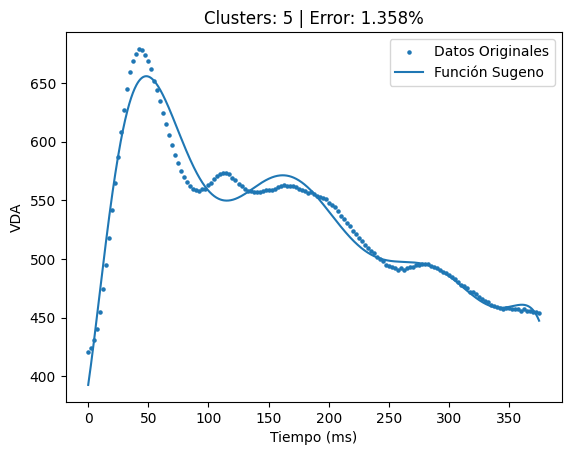

--- Tiempo de ejecucion 0.05002951622009277 seconds ---
21.025939609151216


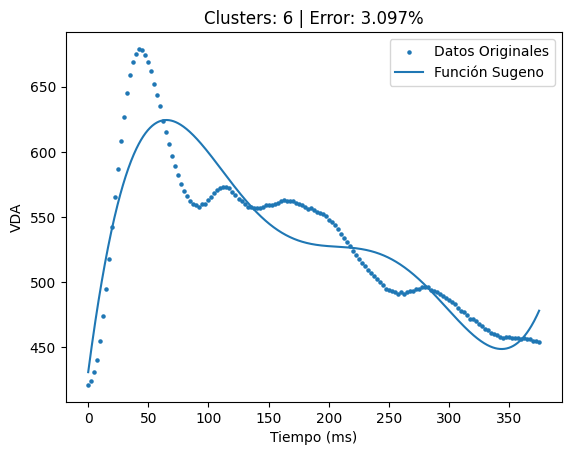

--- Tiempo de ejecucion 0.045334577560424805 seconds ---
5.463226195304625


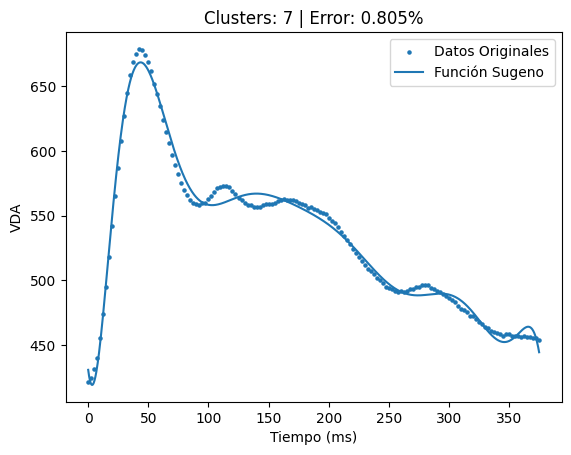

--- Tiempo de ejecucion 0.052300214767456055 seconds ---
9.641071302087736


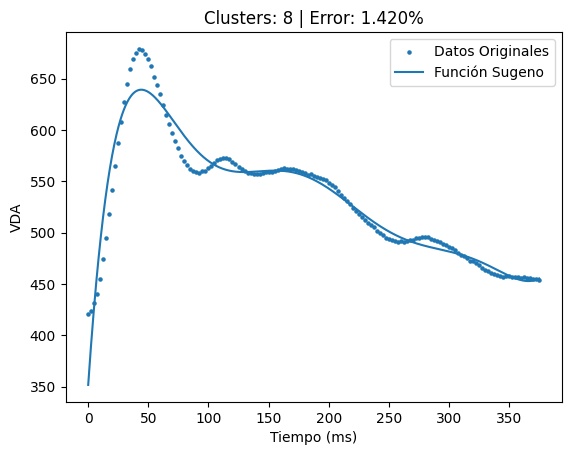

--- Tiempo de ejecucion 0.049249887466430664 seconds ---
5.575195923928292


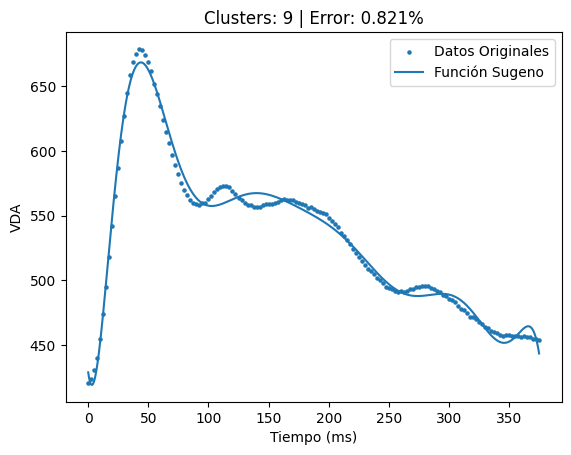

--- Tiempo de ejecucion 0.050153255462646484 seconds ---
9.210963381153922


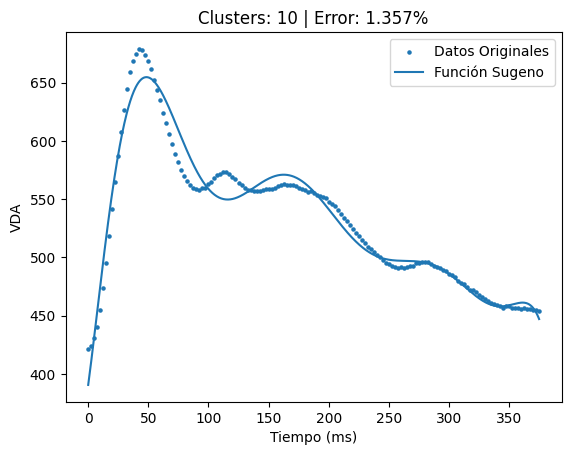

--- Tiempo de ejecucion 0.05492997169494629 seconds ---
4.2832084086633495


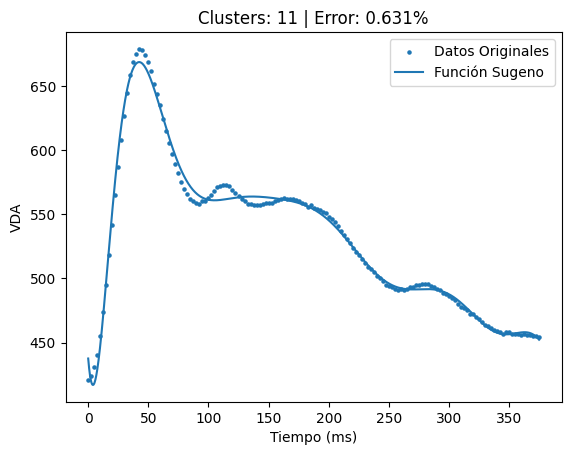

--- Tiempo de ejecucion 0.06837081909179688 seconds ---
10.344087775676481


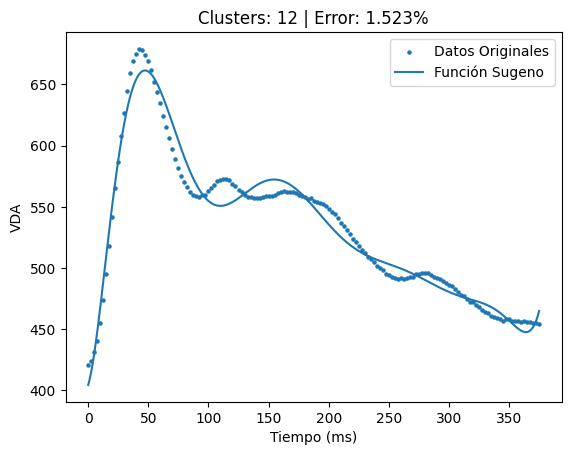

--- Tiempo de ejecucion 0.057756900787353516 seconds ---
4.342883075084237


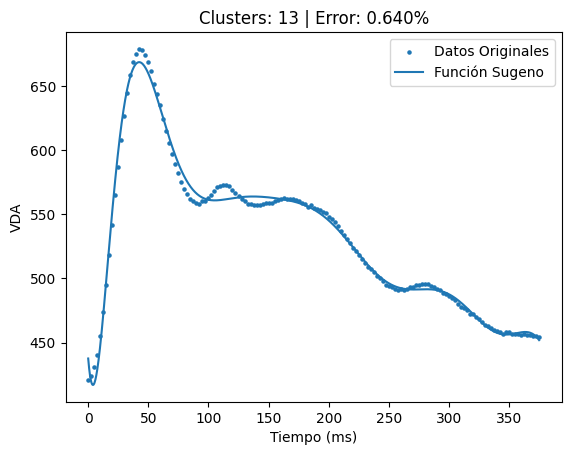

--- Tiempo de ejecucion 0.06869721412658691 seconds ---
5.7175628446763564


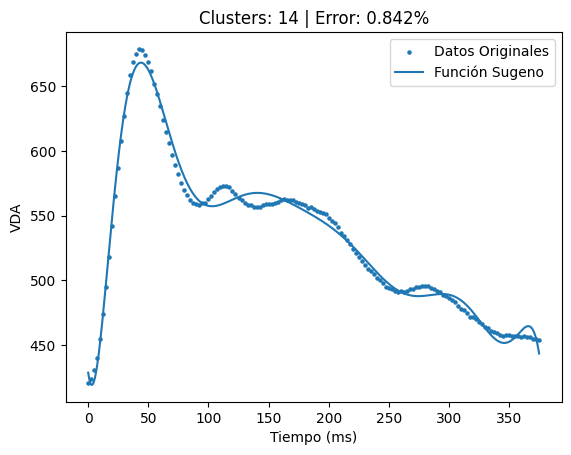

--- Tiempo de ejecucion 0.07393121719360352 seconds ---
3.7223170980878715


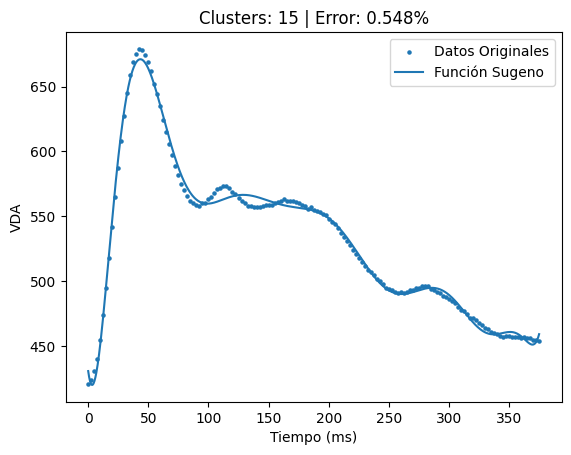

--- Tiempo de ejecucion 0.07522153854370117 seconds ---
5.606029018279044


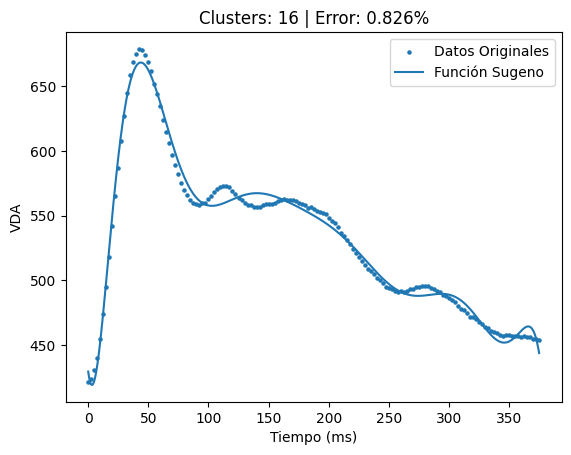

--- Tiempo de ejecucion 0.08107614517211914 seconds ---
3.7510083359065316


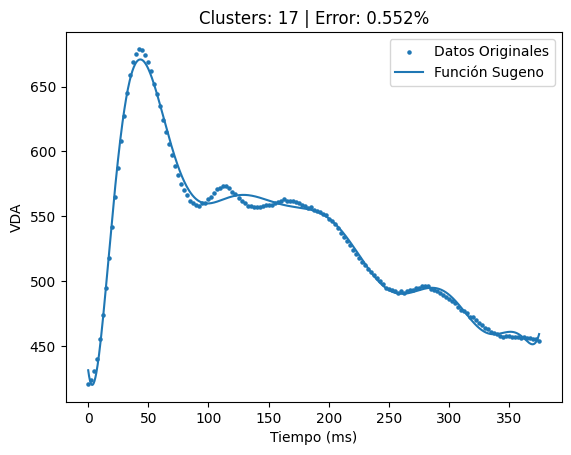

--- Tiempo de ejecucion 0.08353948593139648 seconds ---
5.801601238789097


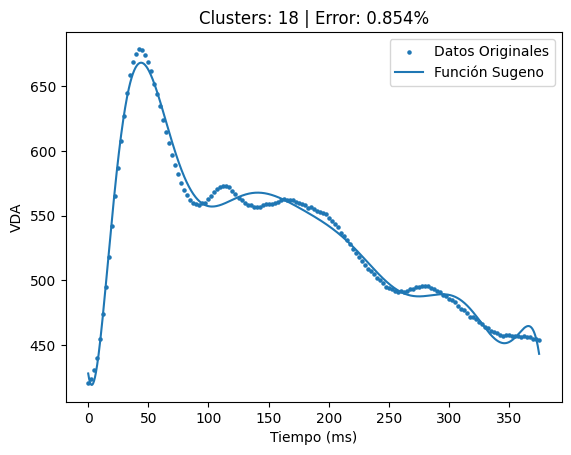

--- Tiempo de ejecucion 0.08869814872741699 seconds ---
3.7995691392270308


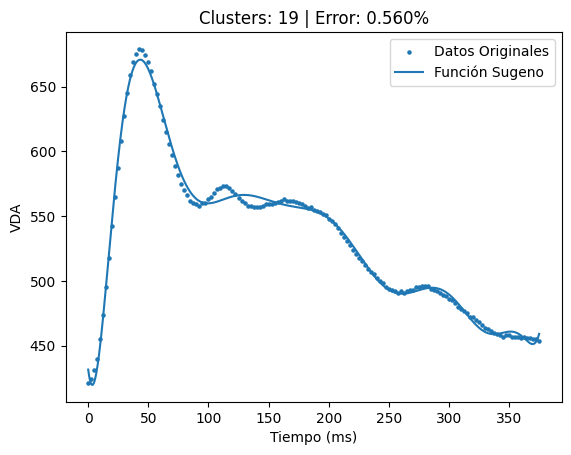

--- Tiempo de ejecucion 0.09257960319519043 seconds ---
3.921200659967238


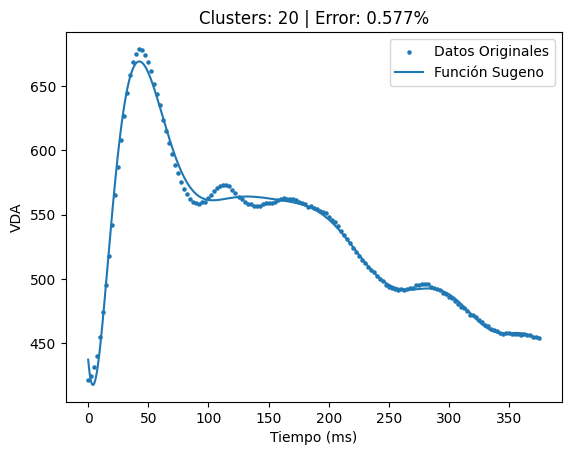

--- Tiempo de ejecucion 0.08292150497436523 seconds ---
3.7821760183620836


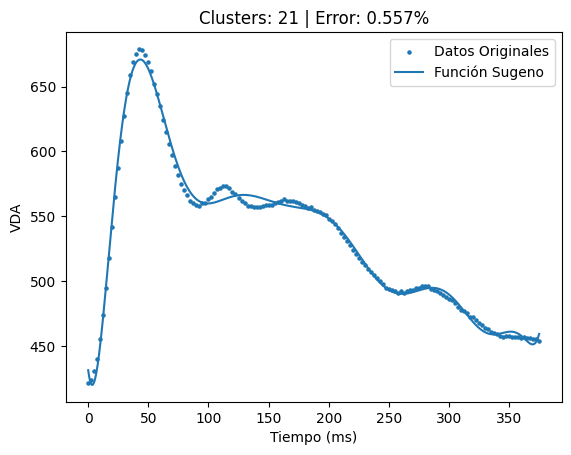

--- Tiempo de ejecucion 0.08738279342651367 seconds ---
4.256922938169971


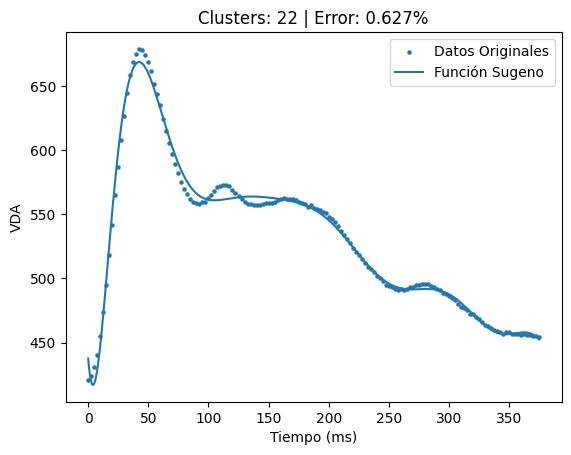

--- Tiempo de ejecucion 0.10870528221130371 seconds ---
3.833817447197714


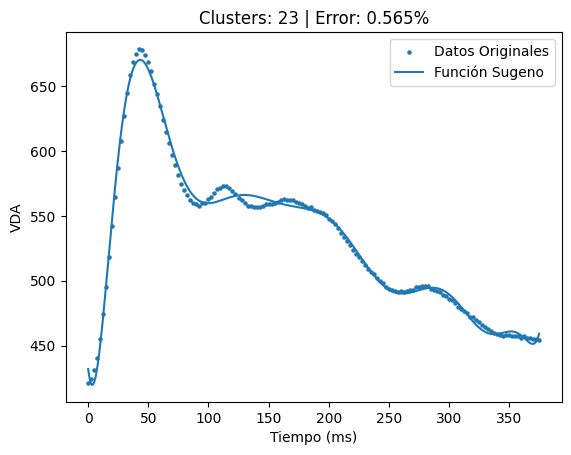

--- Tiempo de ejecucion 0.10349130630493164 seconds ---
4.435570501512097


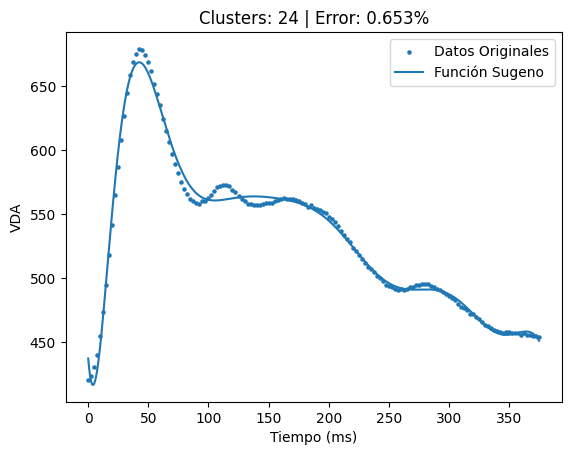

--- Tiempo de ejecucion 0.13132810592651367 seconds ---
3.812506147810528


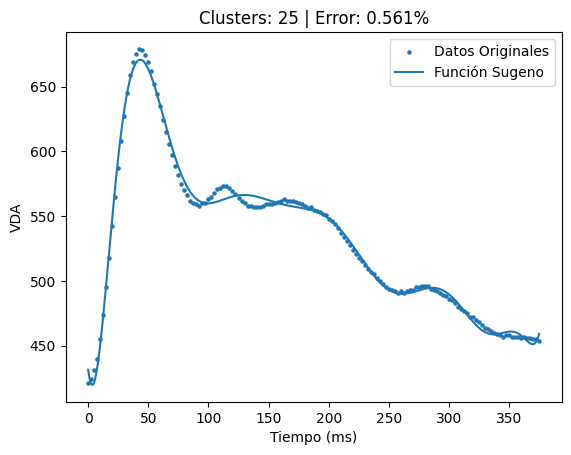

--- Tiempo de ejecucion 0.10076475143432617 seconds ---
4.179207809577366


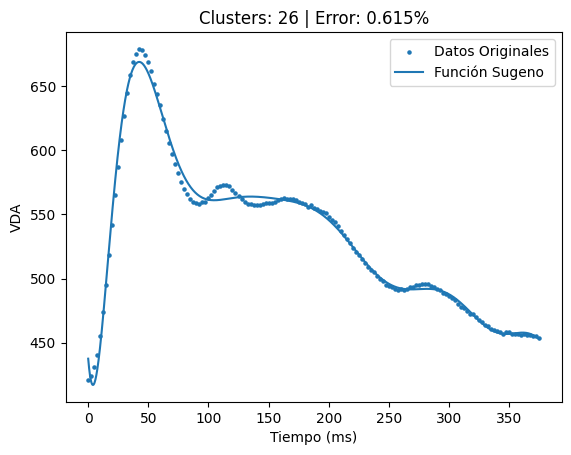

--- Tiempo de ejecucion 0.10503602027893066 seconds ---
3.83696418373485


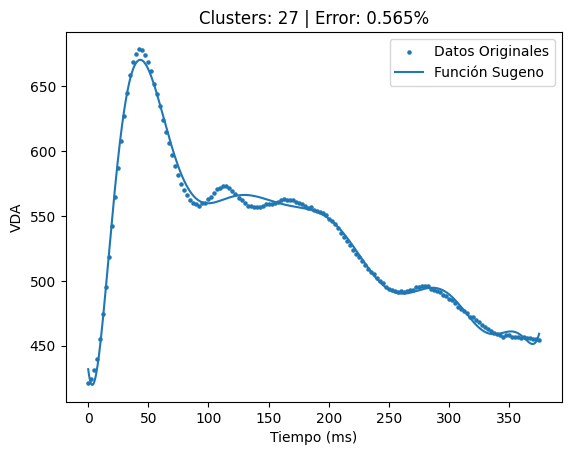

--- Tiempo de ejecucion 0.11133980751037598 seconds ---
4.0271266814201105


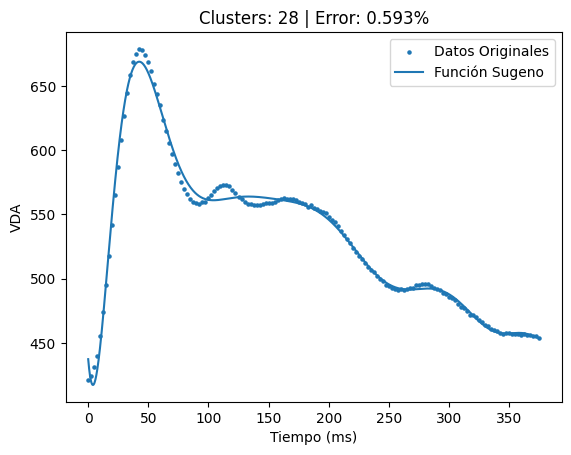

--- Tiempo de ejecucion 0.20838642120361328 seconds ---
3.7872092008286518


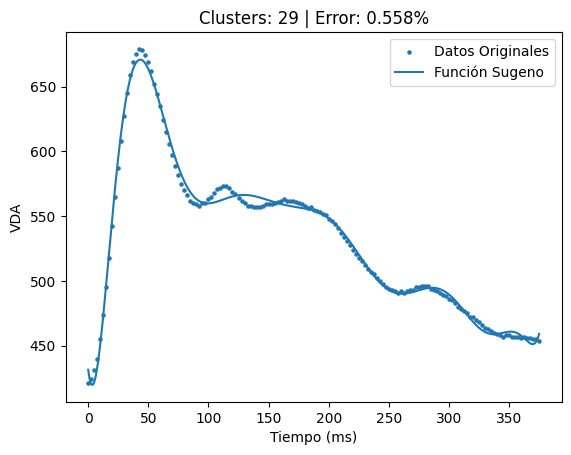

--- Tiempo de ejecucion 0.11518263816833496 seconds ---
4.372572195128493


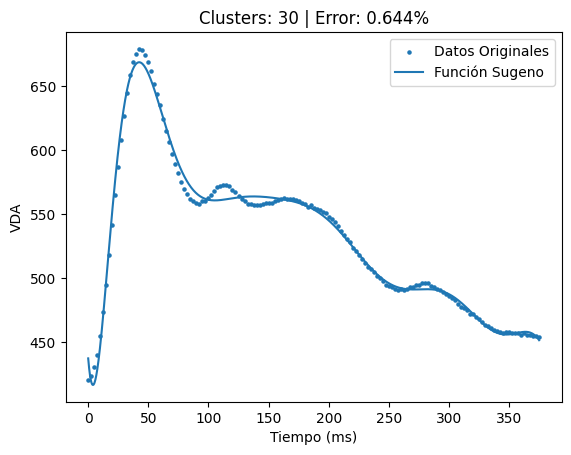

--- Tiempo de ejecucion 0.15766000747680664 seconds ---
3.869737719424114


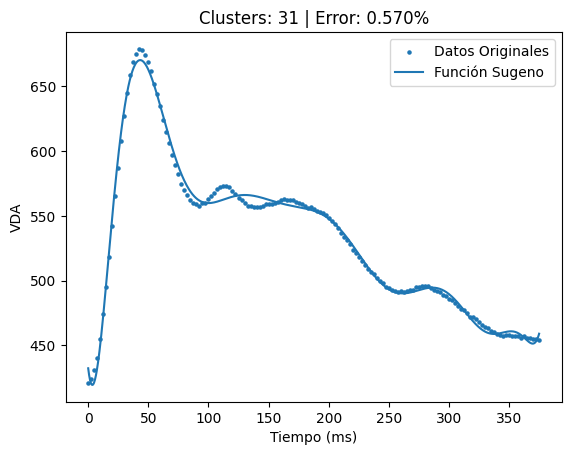

--- Tiempo de ejecucion 0.13228893280029297 seconds ---
4.337577573714718


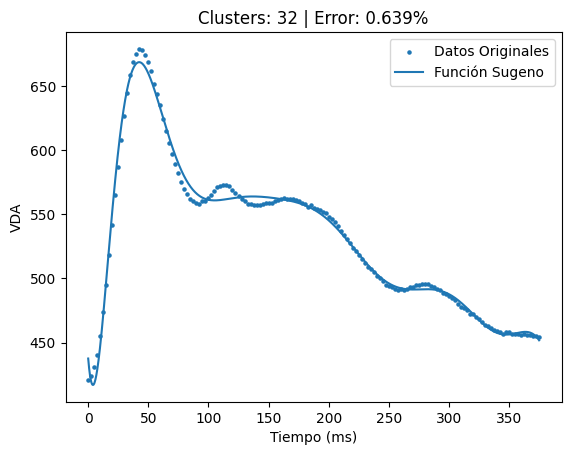

--- Tiempo de ejecucion 0.14838933944702148 seconds ---
3.8073527536626504


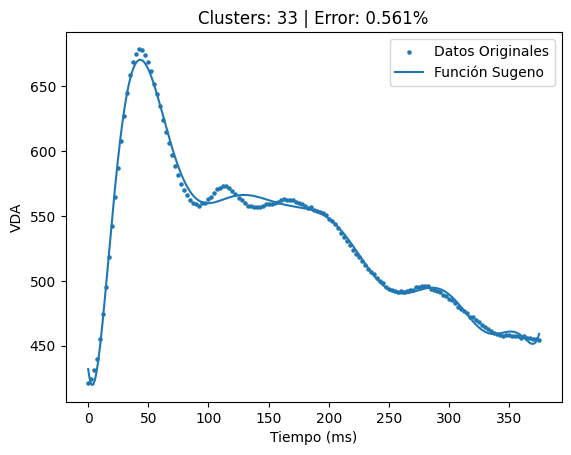

--- Tiempo de ejecucion 0.17153501510620117 seconds ---
4.310897603345614


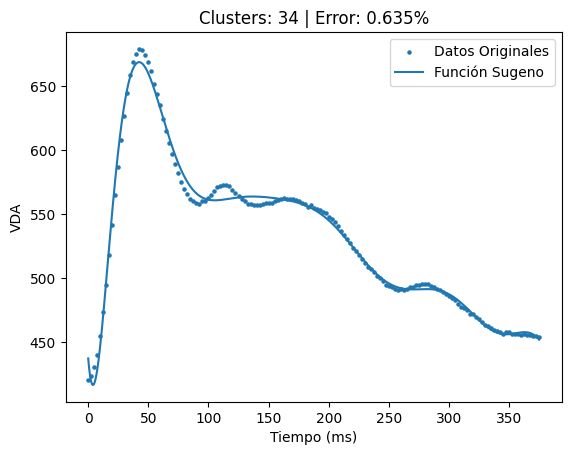

--- Tiempo de ejecucion 0.14261341094970703 seconds ---
3.889920699712445


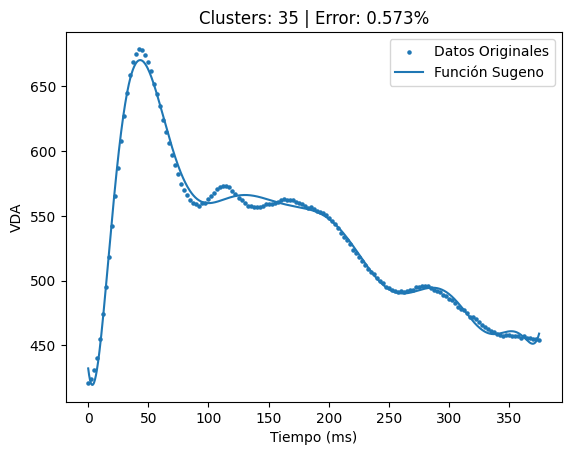

--- Tiempo de ejecucion 0.15489697456359863 seconds ---
3.7865048070107736


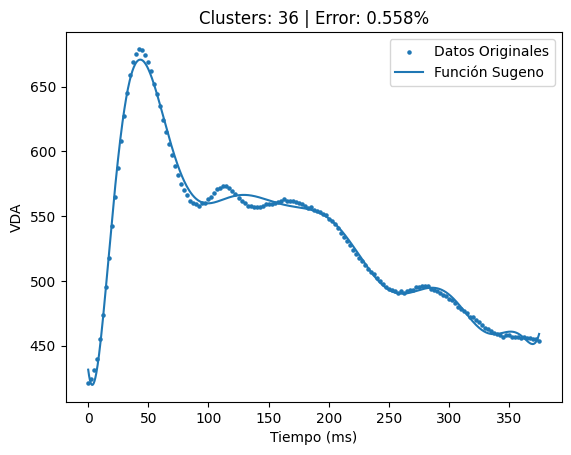

--- Tiempo de ejecucion 0.186570405960083 seconds ---
3.870938221371973


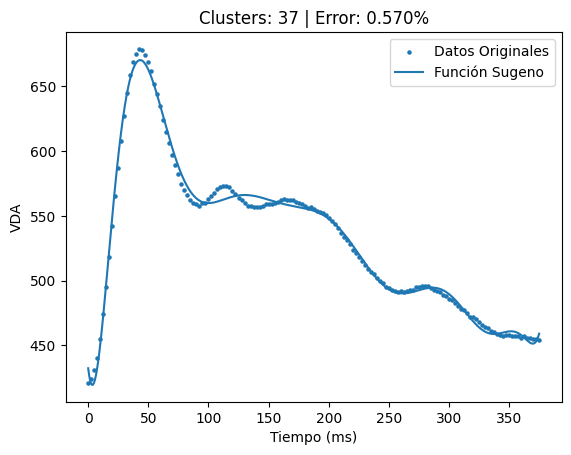

--- Tiempo de ejecucion 0.2340395450592041 seconds ---
4.3748986962065475


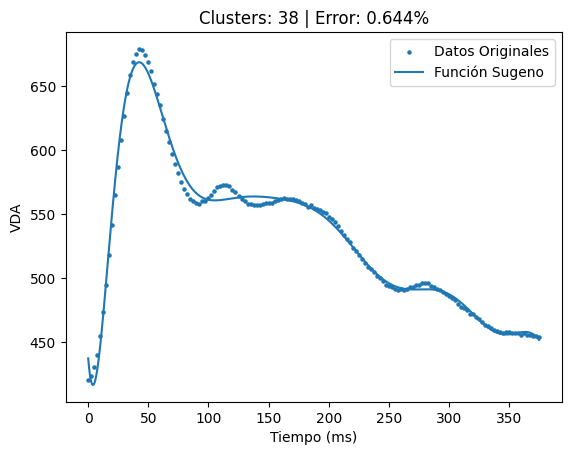

--- Tiempo de ejecucion 0.18497133255004883 seconds ---
3.871020124444077


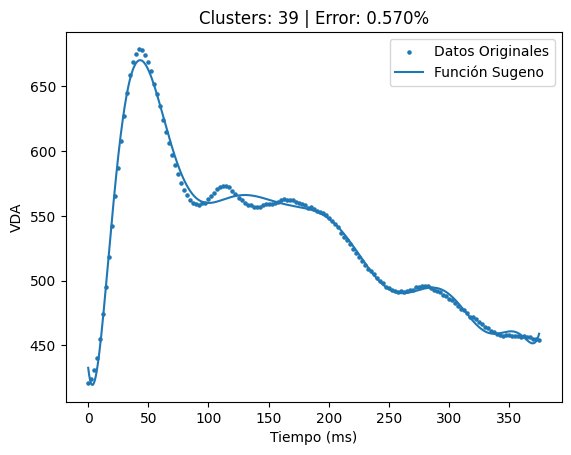

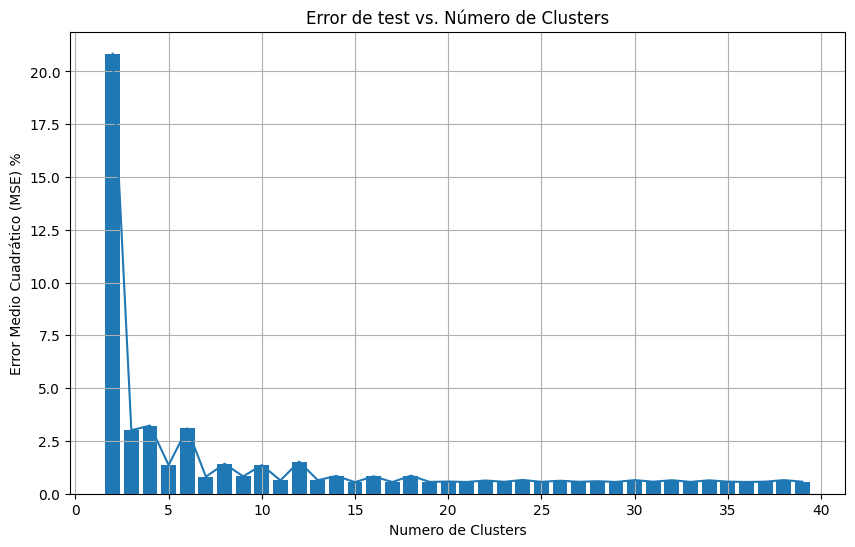

In [67]:
# GRAFICAR EL ERROR vs R
import numpy as np
import matplotlib.pyplot as plt

# Listas para almacenar los valores de error y clusters
mse = []
desde =  2 
hasta = 40
rango_clusters = range(desde, hasta)

for cant_clusters in rango_clusters:
    fis2 = fis()
    fis2.genfis(data, cant_clusters, False)

    x = fis2.evalfis(tiempo_prueba)  # testeo con los vda para testeo
    x = x.reshape(-1,1) 
    error = np.abs(x - vda_prueba)
    # Calcular el promedio de los errores
    promedio_error = np.mean(error)
    print(promedio_error)
    error_promedio_porcentual = promedio_error/np.max(data_y) *100

    mse.append(error_promedio_porcentual)

    # funcion que genero el modelo de sugneo con {cant_clusters} solapada con la data original
    tiempo_prueba_sobremuestrado = np.linspace(np.min(data_x),np.max(data_x),1000)
    tiempo_prueba_sobremuestrado = tiempo_prueba_sobremuestrado.reshape(-1,1) 
    x_sobremuestrado = fis2.evalfis(tiempo_prueba_sobremuestrado)

    

    
    plt.scatter(data_x,data_y,s=5,label='Datos Originales') #todos los datos originales
    plt.plot(tiempo_prueba_sobremuestrado,x_sobremuestrado, label='Función Sugeno') #plt.funcion generada por el sugeno
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('VDA')
    plt.title(f'Clusters: {cant_clusters} | Error: {error_promedio_porcentual:.3f}%')
    plt.legend()
    plt.show()
    """
    print(error.shape)
    print(error)
    plt.scatter(tiempo_prueba,error,s=5) #todos los datos originales
    plt.show()
    """


# Ahora, graficar el error vs. el número de clusters
plt.figure(figsize=(10, 6))
plt.bar(rango_clusters, mse)
plt.plot(rango_clusters, mse)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()


(302,)


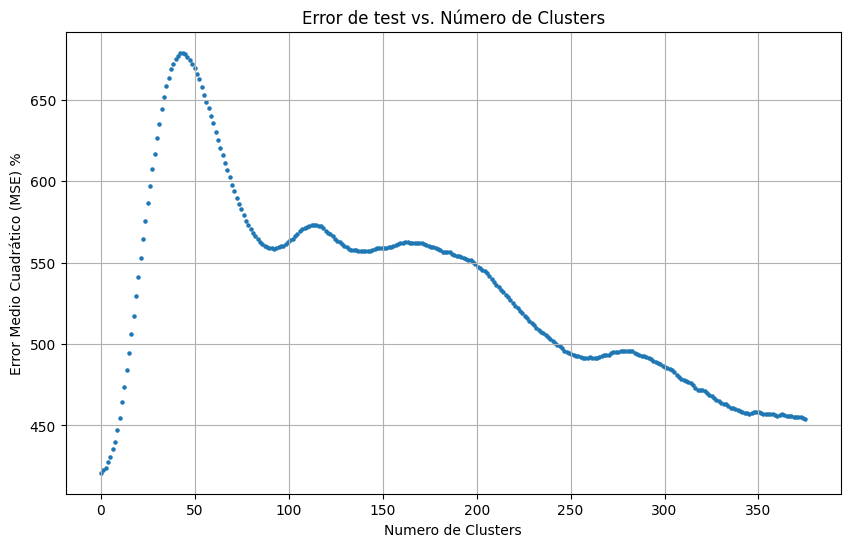

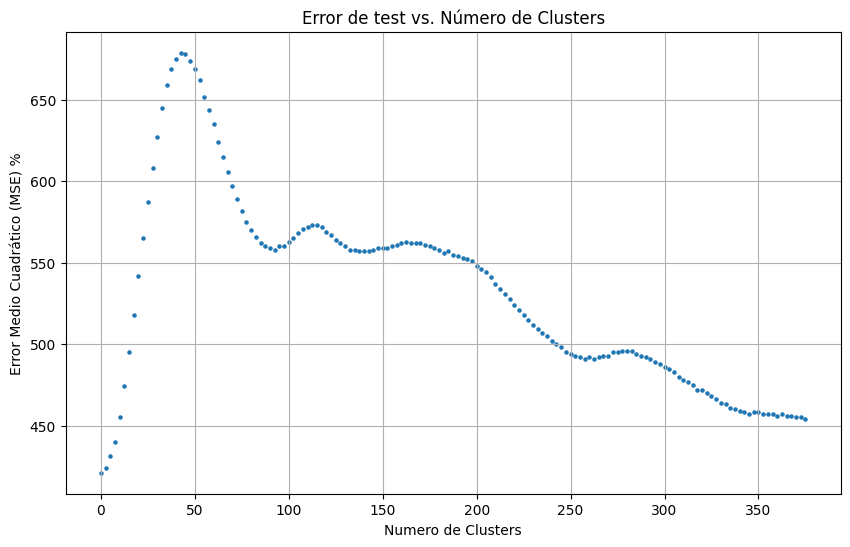

In [30]:
from scipy.interpolate import interp1d

f = interp1d(tiempo, vda, kind='linear')
x_new = np.linspace(0, np.max(tiempo), num=tiempo.shape[0]*2)
y_new = f(x_new)
print(y_new.shape)
#####################################################

plt.figure(figsize=(10, 6))
plt.scatter(x_new, y_new, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(tiempo, vda, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()